<a href="https://colab.research.google.com/github/7Blessings7/Final-Project-CMS204/blob/main/Pair_35_Covid19ContactTracer_Miguel_Katleen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

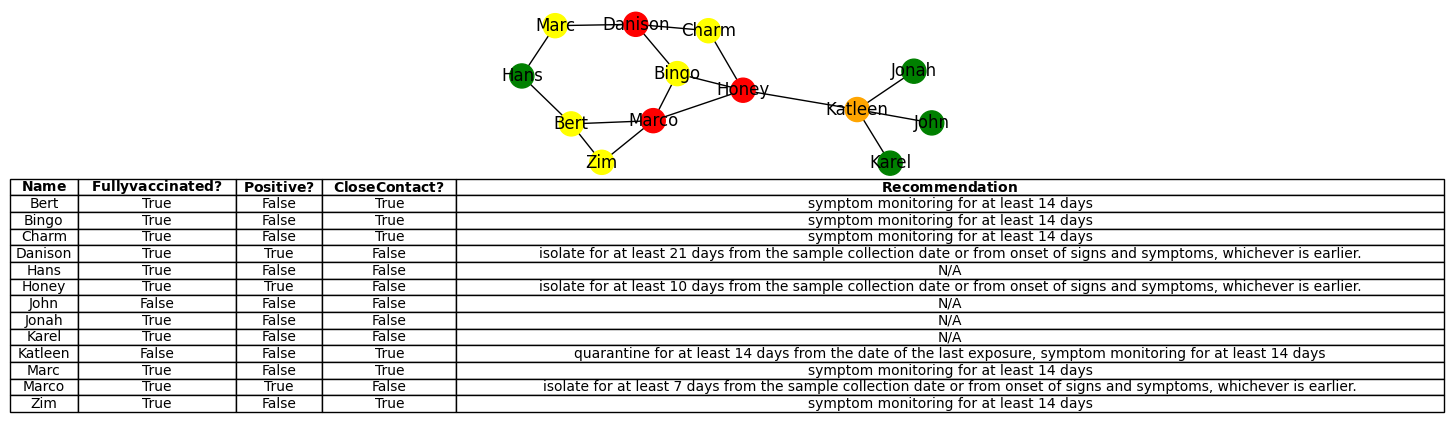

In [ ]:
#import libraries that are used to manipulate and visualize the graph
import matplotlib.pyplot as plt
import networkx as nx


class Person(object):
    # quarantine recommendations based from the DOH recent memorandum
    RECOMMENDATION_CLOSE_CONTACT_FULL = "symptom monitoring for at least 14 days"
    RECOMMENDATION_CLOSE_CONTACT_PARTIAL = "quarantine for at least 14 days from the date of the last exposure, symptom monitoring for at least 14 days"
    RECOMMENDATION_POSITIVE_MILD_PARTIAL = "isolate for at least 10 days from the sample collection date or from onset of signs and symptoms, whichever is earlier."
    RECOMMENDATION_POSITIVE_MILD_FULL = "isolate for at least 7 days from the sample collection date or from onset of signs and symptoms, whichever is earlier."
    RECOMMENDATION_POSITIVE_MODERATE = "isolate for at least 10 days from the sample collection date or from onset of signs and symptoms, whichever is earlier."
    RECOMMENDATION_POSITIVE_CRITICAL = "isolate for at least 21 days from the sample collection date or from onset of signs and symptoms, whichever is earlier."

    # symptom severity
    POSITIVE_MILD = "mild"
    POSITIVE_MODERATE = "moderate"
    POSITIVE_CRITICAL = "critical"

    instances = set()

    # sets the person's name and vaccination status and initializes other attributes
    # it also adds the instance to a class-level set of all 'Person' instances
    def __init__(
        self,
        contact_name, 
        vaccine_first_dose,
        vaccine_second_dose,
    ):
        self.name = contact_name # name
        self.vaccine_first_dose = vaccine_first_dose  # vaccination status
        self.vaccine_second_dose = vaccine_second_dose  # vaccination status

        self.close_contacts = set()

        self.is_positive = False # COVID-19 status
        self.positive_intensity = None

        self.risk_level = 0

        self.__class__.instances.add(self)

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name

    @property

    # employee is fully vaccination if he/she has 2 doses of vaccinations
    def is_fully_vaccinated(self):
        return self.vaccine_first_dose and self.vaccine_second_dose

    # adds another Person instance to this Person's close_contacts set and adds this Person to the other Person's close_contacts set. 
    # if this Person is positive for COVID-19, the other Person's risk_level attribute is incremented. 
    # if the other Person is positive for COVID-19, this Person's risk_level attribute is incremented.
    def add_contact(self, contact):
        self.close_contacts.add(contact)
        contact.close_contacts.add(self)

        if self.is_positive:
            contact.risk_level += 1

        if contact.is_positive:
            self.risk_level += 1

    # sets this Person as positive for COVID-19 with the given intensity
    # increments the risk_level attribute for all close_contacts of this Person
    def set_as_positive(self, intensity):
        self.is_positive = True
        self.positive_intensity = intensity

        for close_contact in self.close_contacts:
            close_contact.risk_level += 1

    @classmethod
    # generates a graph that shows the relationships between Person instances
    # the nodes of the graph represent Person instances and the edges represent close contacts between Person instances
    # the color of a node depends on the COVID-19 status and vaccination status of the corresponding Person instance.
    # the graph also shows a table with recommendations for each Person instance based on their COVID-19 status, vaccination status, and close contacts.
    def generate_graph(cls):
        graph = nx.Graph()
        persons = cls.get_instances()
        colors = []

        graph.add_nodes_from([person.name for person in persons])

        table_data = [
            [
                "$\\bf{Name}$",
                "$\\bf{Fully vaccinated?}$",
                "$\\bf{Positive?}$",
                "$\\bf{Close Contact?}$",
                "$\\bf{Recommendation}$",
            ],
        ]
        person_data = []

        #generates close contacts network
        for person in persons:
            for close_contact in person.close_contacts:
                graph.add_edge(person.name, close_contact.name)

            data = [
                person.name,
                str(bool(person.is_fully_vaccinated)),
                str(person.is_positive),
                str(bool(person.risk_level and not person.is_positive)),
            ]

            if person.is_positive:
                if (
                    person.positive_intensity == Person.POSITIVE_MILD
                    and person.is_fully_vaccinated
                ):
                    data.append(Person.RECOMMENDATION_POSITIVE_MILD_FULL)
                elif person.positive_intensity == Person.POSITIVE_MILD:
                    data.append(Person.RECOMMENDATION_POSITIVE_MILD_PARTIAL)
                elif person.positive_intensity == Person.POSITIVE_MODERATE:
                    data.append(Person.RECOMMENDATION_POSITIVE_MODERATE)
                elif person.positive_intensity == Person.POSITIVE_CRITICAL:
                    data.append(Person.RECOMMENDATION_POSITIVE_CRITICAL)
                colors.append("red") # employee positive for covid 19
            elif person.risk_level and person.is_fully_vaccinated:
                data.append(Person.RECOMMENDATION_CLOSE_CONTACT_FULL)
                colors.append("yellow") # fully vaccinated employee who is a close contact
            elif person.risk_level:
                data.append(Person.RECOMMENDATION_CLOSE_CONTACT_PARTIAL)
                colors.append("orange") # partially vaccinated or unvaccinated employee who is a close contact
            else:
                data.append("N/A")
                colors.append("green") # employee who is not a close contact

            person_data.append(data)

        person_data = sorted(person_data, key=lambda x: x[0]) # sorts employee names alphabetically for the table
        table_data += person_data

        fig, axs = plt.subplots(nrows=2)

        # hide axes
        for ax in axs:
            ax.axis("off")

        # create graph
        nx.draw(graph, ax=axs[0], node_color=colors, with_labels=True)

        # create table
        table = axs[1].table(cellText=table_data, colLabels=None, cellLoc="center", loc="center")
        table.auto_set_column_width(col=list(range(len(table_data[0]))))

        plt.draw_if_interactive()
        plt.savefig("filename.png", bbox_inches="tight", dpi=150)

    @classmethod
    def get_instances(cls):
        return cls.instances

    @classmethod
    def get_instance(cls, contact_name):
        return next(
            (
                instance
                for instance in cls.instances
                if instance.name == contact_name
            ),
            None,
        )

    @classmethod
    
    def import_from_data(cls, records):
        imported_data = set()

        for record in records:
            person = cls.get_instance(record[0])
            if person is None:
                person = cls(record[0], record[1], record[2])
                imported_data.add(person)

        cls.instances = cls.instances.union(imported_data)

        return imported_data

    @classmethod
    # method imports COVID-19 positive status for Person instances from a list of records. 
    # each record is a tuple of two elements: name and positive_intensity. 
    # if a Person instance with the given name exists in instances, 
    # that Person instance is updated with the positive status. 
    def import_positive_from_data(cls, records):
        imported_data = set()

        for name, status in records:
            person = cls.get_instance(name)
            if person:
                person.set_as_positive(status)
                imported_data.add(person)

        return imported_data

    @classmethod
    # imports close contact information from a list of records
    def import_close_contacts_from_data(cls, records):
        for record in records:
            person_name = record[0]
            close_contact_names = record[1]

            person = cls.get_instance(person_name)
            if person:
                for close_contact_name in close_contact_names:
                    close_contact = cls.get_instance(close_contact_name)
                    if close_contact:
                        person.add_contact(close_contact)


if __name__ == "__main__":
    # vaccination records: name, first dose?, second dose? 
    records = [
        ["Katleen", True, False],
        ["Jonah", True, True],
        ["Karel", True, True],
        ["John", False, False],
        ["Honey", True, True],
        ["Charm", True, True],
        ["Marco", True, True],
        ["Bingo", True, True],
        ["Bert", True, True],
        ["Zim", True, True],
        ["Danison", True, True],
        ["Marc", True, True],
        ["Hans", True, True],
    ]
    # record of people positive for COVID-19
    positives = [
        ["Marco", Person.POSITIVE_MILD],
        ["Honey", Person.POSITIVE_MODERATE],
        ["Danison", Person.POSITIVE_CRITICAL],
    ]
    # reported close contacts
    contacts = [
        ["Katleen", ["Jonah", "Karel", "John", "Honey"]],
        ["Honey", ["Charm", "Marco", "Bingo"]],
        ["Marco", ["Bert", "Zim"]],
        ["Bingo", ["Marco", "Danison"]],
        ["Charm", ["Danison"]],
        ["Marc", ["Danison"]],
        ["Bert", ["Hans", "Zim"]],
        ["Hans", ["Marc"]],
    ]

    Person.import_from_data(records)
    Person.import_positive_from_data(positives)
    Person.import_close_contacts_from_data(contacts)

    Person.generate_graph()